# Validation Set with Manual Review
This notebook contains the implementation and evaluation of various neural network models with differing paremeters.

In [17]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport manual_review_classifier

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
%matplotlib inline

In [19]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot, make_model_output_plot
from manual_review_classifier.Analysis import determine_feature_importance, print_accuracy_and_classification_report, predict_classes, get_somatic_error_type, calculate_kappa
from zero_one_based_conversion import convert
from manual_review_classifier.ReadCount import ReadCount

pd.set_option('display.max_colwidth', -1)

sns.set_style("white")
sns.set_context('talk')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

In [38]:
# Pull in training data
training_data = pd.read_pickle('../data/training_data.pkl')

In [39]:
# Fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Set parameters for cross-validation fold splits
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [40]:
# Remove disease labels
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [41]:
# Get Labels
Y = pd.get_dummies(three_class.call, columns=['a','f','s']).astype(float).values
# Get training data as numpy array, remove reviews because of non overlap
s_v_b = s_v_b.drop(['call', 'reviewer_1',
                'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1)
X = s_v_b.sort_index(axis=1).astype(float).values

In [8]:
# define baseline model
def model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.01)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
estimator = KerasClassifier(build_fn=model, epochs=1000, batch_size=2000, verbose=0)

In [10]:
estimator.fit(X, Y)

In [11]:
# Develop cross validation predictions
if not os.path.exists('../data/deep_learning/threeclass_regularization.npy'):
    probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')
    np.save('../data/deep_learning/threeclass_relu_probs.npy', probabilities)
else:
    probabilities = np.load('../data/deep_learning/threeclass_regularization.npy')
    
# Pull maximum probability to determine call
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

# Analyze predicted labels
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

# Prepare Data

In [2]:
def parse_samples_file(samples_file_path, header):
    
    with open(samples_file_path) as f:
        samples = f.readlines()
        samples = [x.strip() for x in samples]
        samples = [x.split('\t') for x in samples]
        if header:
            samples.pop(0)
    return samples

def run_bam_readcount(skip_readcount, out_dir_path, samples, name):
    out_dir_path = os.path.join(out_dir_path, 'readcounts')
    if not os.path.exists(out_dir_path):
        os.makedirs(out_dir_path)
    review = pd.DataFrame(columns=['chromosome', 'start', 'stop',
                                        'ref', 'var', 'call', 'reviewer'])
    for sample in samples:
        print('-----------------------------------------------------'
              '\nStarting on sample {0}\n'.format(sample[0]))
        reviewer_specified_in_sample = False
        sites_file_path = os.path.join(out_dir_path, sample[0] + '.sites')
        review = parse_review_file(sample[3], sites_file_path,
                                         sample[0])
        reviewer_in_bed_file = 'reviewer' in review.columns
        review['disease'] = sample[4]
        review = pd.concat([review, review], ignore_index=True)
        bed_one_based_f_path = sample[3] + '.one_based'
        print('Processing tumor bam file:\n\t{0}'.format(sample[1]))
        tumor_readcount_file_path = '{0}/{1}_tumor' \
                                    '.readcounts'.format(out_dir_path,
                                                         sample[0])
        if not skip_readcount:
            os.system('bam-readcount -i -w 0 -l {0} -f {1} '
                      '{2} > {3}'.format(sites_file_path, sample[5],
                                         sample[1],
                                         tumor_readcount_file_path))

        tumor_rc = ReadCount(tumor_readcount_file_path)

        tumor_data = tumor_rc.compute_variant_metrics(bed_one_based_f_path,
                                                      'tumor',
                                                      reviewer_in_bed_file,
                                                      sample[5])
        print('Processing normal bam file:\n\t{0}'.format(sample[2]))
        normal_readcount_file_path = '{0}/{1}_normal' \
                                     '.readcounts'.format(out_dir_path,
                                                          sample[0])
        if not skip_readcount:
            os.system('bam-readcount -i -w 0 -l {0} -f {1} '
                      '{2} > {3}'.format(sites_file_path, sample[5],
                                         sample[2],
                                         normal_readcount_file_path))
        normal_rc = ReadCount(normal_readcount_file_path)
        normal_data = normal_rc.\
            compute_variant_metrics(bed_one_based_f_path, 'normal',
                                    reviewer_in_bed_file, sample[5])
        if len(tumor_data) != len(normal_data):
            raise ValueError(
                'Dataframes cannot be merged. They are differing lengths.')
        else:
            individual_df = pd.merge(tumor_data, normal_data,
                                     on=['chromosome', 'start', 'stop',
                                         'ref', 'var', 'call', 'disease'])
        individual_df.index = (sample[0] + '~' + individual_df.chromosome +
                               ':' + individual_df.start.map(str) + '-' +
                               individual_df.stop.map(str) +
                               individual_df.ref + '>' +
                               individual_df['var'])
        training_data = pd.DataFrame()
        training_data = pd.concat([training_data, individual_df])

    training_data.drop(['chromosome', 'start', 'stop', 'ref', 'var'],
                            axis=1, inplace=True)
    #perform_one_hot_encoding('disease', training_data)
    calls = training_data.pop('call')

    # normalize continuous variables
    columns = ['normal_VAF', 'normal_depth', 'normal_other_bases_count',
               'normal_ref_avg_basequality',
               'normal_ref_avg_clipped_length',
               'normal_ref_avg_distance_to_effective_3p_end',
               'normal_ref_avg_distance_to_q2_start_in_q2_reads',
               'normal_ref_avg_mapping_quality',
               'normal_ref_avg_num_mismaches_as_fraction',
               'normal_ref_avg_pos_as_fraction',
               'normal_ref_avg_se_mapping_quality',
               'normal_ref_avg_sum_mismatch_qualities', 'normal_ref_count',
               'normal_ref_num_minus_strand', 'normal_ref_num_plus_strand',
               'normal_ref_num_q2_containing_reads',
               'normal_var_avg_basequality',
               'normal_var_avg_clipped_length',
               'normal_var_avg_distance_to_effective_3p_end',
               'normal_var_avg_distance_to_q2_start_in_q2_reads',
               'normal_var_avg_mapping_quality',
               'normal_var_avg_num_mismaches_as_fraction',
               'normal_var_avg_pos_as_fraction',
               'normal_var_avg_se_mapping_quality',
               'normal_var_avg_sum_mismatch_qualities', 'normal_var_count',
               'normal_var_num_minus_strand', 'normal_var_num_plus_strand',
               'normal_var_num_q2_containing_reads', 'tumor_VAF',
               'tumor_depth',
               'tumor_other_bases_count', 'tumor_ref_avg_basequality',
               'tumor_ref_avg_clipped_length',
               'tumor_ref_avg_distance_to_effective_3p_end',
               'tumor_ref_avg_distance_to_q2_start_in_q2_reads',
               'tumor_ref_avg_mapping_quality',
               'tumor_ref_avg_num_mismaches_as_fraction',
               'tumor_ref_avg_pos_as_fraction',
               'tumor_ref_avg_se_mapping_quality',
               'tumor_ref_avg_sum_mismatch_qualities', 'tumor_ref_count',
               'tumor_ref_num_minus_strand', 'tumor_ref_num_plus_strand',
               'tumor_ref_num_q2_containing_reads',
               'tumor_var_avg_basequality',
               'tumor_var_avg_clipped_length',
               'tumor_var_avg_distance_to_effective_3p_end',
               'tumor_var_avg_distance_to_q2_start_in_q2_reads',
               'tumor_var_avg_mapping_quality',
               'tumor_var_avg_num_mismaches_as_fraction',
               'tumor_var_avg_pos_as_fraction',
               'tumor_var_avg_se_mapping_quality',
               'tumor_var_avg_sum_mismatch_qualities', 'tumor_var_count',
               'tumor_var_num_minus_strand', 'tumor_var_num_plus_strand',
               'tumor_var_num_q2_containing_reads']
    to_normalize = training_data[columns]
    x = to_normalize.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    scaled = pd.DataFrame(x_scaled, index=training_data.index,
                          columns=columns)
    training_data.to_pickle(os.path.join(out_dir_path, name + 'train.pkl'))
    calls.to_pickle(os.path.join(out_dir_path, name + 'call.pkl'))

def perform_one_hot_encoding(column, training_data):
    """perform one-hot encoding on categorical variables

        Args:
            column (str): Column name to perform encoding on

    """
    get_dummies = pd.get_dummies(training_data[column], prefix=column)
    categorical_columns = list()
    categorical_columns += get_dummies.columns.values.tolist()
    training_data = pd.concat([training_data, get_dummies],
                                   axis=1)
    training_data.drop(column, axis=1, inplace=True)

def parse_review_file(manual_review_file_path, sites_file_path,
                       sample_name):
    manual_review = pd.read_csv(manual_review_file_path, sep='\t')
    manual_review.columns = map(str.lower, manual_review.columns)
    manual_review.rename(columns={'reference': 'ref', 'variant': 'var'},
                         inplace=True)
    manual_review = manual_review[['chromosome', 'start', 'stop',
                                       'ref', 'var', 'call']]
    manual_review = manual_review.apply(convert_one_based, axis=1)
    manual_review = manual_review.replace('', np.nan).dropna(how='all')
    manual_review[['chromosome', 'start', 'stop']].to_csv(sites_file_path,
                                                          sep='\t',
                                                          index=False,
                                                          header=False)
    manual_review.to_csv(manual_review_file_path+'.one_based', sep='\t',
                         index=False, header=True)
    return manual_review

def convert_one_based(row):
    return convert.coordinate_system('\t'.join(map(str, row.values)),
                                     'to_one_based').strip().split('\t')


def determine_independent_test_performance(training_data_path,
                                          calls_path, tumor_type,
                                          cols_to_drop, 
                                          estimator,
                                          calls_out_path,
                                          probs_out_path,
                                          test_set_display_name):
    data = pd.read_pickle(training_data_path)
    data['solid_tumor'] = tumor_type
    call = pd.read_pickle(calls_path)
    call=call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
    print(call.value_counts())
    # Get Labels
    Y = pd.get_dummies(call, columns=['a','f','s']).astype(float).values
    # Get training data as numpy array
    X = data.sort_index(axis=1).drop(cols_to_drop, axis=1).astype(float).values

    probs = estimator.predict_proba(X)
    np.save(calls_out_path, Y)
    np.save(probs_out_path, probs)
    fig, ax = plt.subplots()
    create_roc_curve(Y, probs, class_lookup, 
                     'Receiver Operating Characteristic - '+
                     test_set_display_name+
                     ' - Deep Learning', ax)
    fig, ax = plt.subplots(figsize=(8,6),dpi=100)
    lgd = create_reliability_diagram(probs, Y,
                                     ['Ambiguous','Fail','Somatic'], 
                                     'cornflowerblue', 
                                     'Reliability Diagram - '+
                                     test_set_display_name+
                                     ' - Deep Learning',
                                     ax, True, True, True)
    lgd.set_bbox_to_anchor((0.1, .85))
    fig, ax = plt.subplots(figsize=(8,6),dpi=100)
    make_model_output_plot(probs, 'Deep learning output distributions -'
                           ' '+test_set_display_name+' test set')
    label_binarizer.fit(range(max(estimator.predict(X))+1))
    predicted_transformed = label_binarizer.transform(estimator.predict(X))
    print('Kappa: ', calculate_kappa(predicted_transformed+Y))
    print('Cohen\'s Kappa: ', metrics.cohen_kappa_score(np.argmax(Y, axis=1), estimator.predict(X)))
    return X, Y, probs


def calculate_retraining_improvement(independent_test_X, independent_test_Y,
                                    X, Y, estimator, random_seed):
    auc = []
    for i in np.arange(0, 0.8, 0.05):
        if i == 0:
            independent_test_X_test = independent_test_X
            independent_test_Y_test = independent_test_Y
            X_train = X
            Y_train = Y
        else:
            (independent_test_X_train, 
             independent_test_X_test, 
             independent_test_Y_train, 
             independent_test_Y_test) = train_test_split(independent_test_X, 
                                                         independent_test_Y,
                                                         train_size=i,
                                                         random_state=seed,
                                                         stratify=\
                                                         independent_test_Y) 
            X_train = np.concatenate((X, independent_test_X_train))
            Y_train = np.concatenate((Y, independent_test_Y_train))
        print('Percentage of test data included in training: ', i*100)
        print('Training data shape: ', X_train.shape)
        print('Test data shape: ', independent_test_X_test.shape)
        print('Number of test samples included in training: ', 
              X_train.shape[0]-X.shape[0])
        estimator.fit(X_train, Y_train)
        X_test_probs = estimator.predict_proba(independent_test_X_test)
        print_accuracy_and_classification_report(independent_test_Y_test, 
                                                 predict_classes(X_test_probs
                                                                )
                                                )
        temp_auc = []
        temp_auc.append(X_train.shape[0]-X.shape[0])
        for j in range(Y.shape[1]):
            temp_auc.append(metrics.roc_auc_score(
                independent_test_Y_test[:, j], X_test_probs[:, j]))
        auc.append(temp_auc)
        print('Test AUC: ', temp_auc)
        print('---------------------------------------------------------')
    return auc


def create_batch_effect_retraining_figure(auc, fig_out_name):
    auc = pd.DataFrame(auc, columns=['num. variants in training','ambiguous', 'fail','somatic'])
    fig, ax = plt.subplots(1, 1)
    auc.plot(x='num. variants in training', y='somatic', ax=ax, 
                  color='black')
    ax.plot([0, auc['num. variants in training'].max()],
            [.96,.96], linestyle='--', dashes=(5, 5),color='black', 
            label='somatic cross validation')
    auc.plot(x='num. variants in training', y='fail', ax=ax, 
                  color='red')
    ax.plot([0, auc['num. variants in training'].max()], 
            [.99,.99], linestyle='--', dashes=(5, 5),color='red', 
            label='fail cross validation')
    auc.plot(x='num. variants in training', y='ambiguous', ax=ax, 
                  color='darkorange')
    ax.plot([0, auc['num. variants in training'].max()], 
            [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', 
            label='ambiguious cross validation')
    ax.legend(loc=4,frameon=True)
    ax.set_ylim([0,1.0])
    ax.set_ylabel('AUC Attained After Training', fontsize=22)
    ax.set_xlabel('Number of Variants used to re-train the Model', fontsize=22)
    ax.set_title('', fontsize=24)
    fig.set_size_inches(10, 8)
    plt.show()
    fig.savefig(fig_out_name+'.png', bbox_inches='tight', dpi=1000)

# SCLC Validation

In [3]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
sclc_X, sclc_Y, sclc_probs = determine_independent_test_performance('../data/independent_test/sclc_train.pkl',
                                          '../data/independent_test/sclc_call.pkl', 1,
                                          ['disease_SCLC', 'reviewer_Lee', 'reviewer_Erica'], 
                                          estimator,
                                          '../data/independent_test/output_path/',
                                          '../data/independent_test/probability/',
                                          "SCLC")

NameError: name 'estimator' is not defined

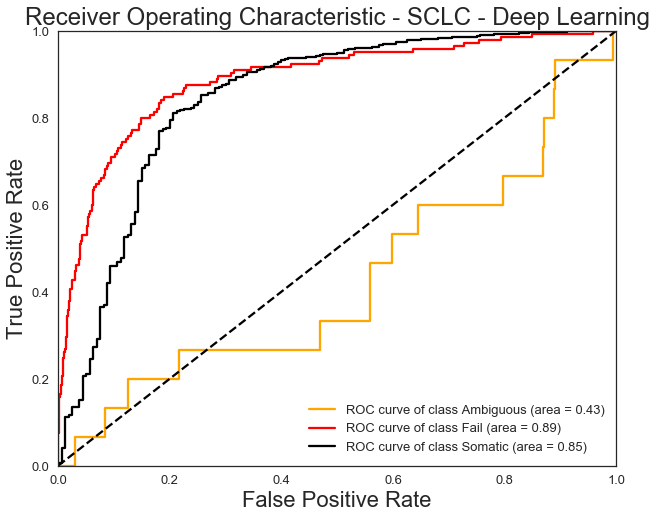

In [55]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(sclc_Y, sclc_probs, class_lookup, 
                 'ROC - SCLC - Deep Learning', ax)
ax.set_ylabel('True Positive Rate', fontsize=22)
ax.set_xlabel('False Positive Rate', fontsize=22)
ax.set_title('Receiver Operating Characteristic - SCLC - Deep Learning', fontsize=24)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/SCLC_ROC.png', bbox_inches='tight', dpi=1000)

In [45]:
sclc_auc = calculate_retraining_improvement(sclc_X, sclc_Y, X, Y, estimator, 7)

Percentage of test data included in training:  0.0
Training data shape:  (41832, 59)
Test data shape:  (2686, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.925539836188

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        15
          1       0.72      0.16      0.26       145
          2       0.96      0.98      0.97      2526

avg / total       0.94      0.93      0.92      2686

Test AUC:  [0, 0.42503431923124924, 0.88717176240687201, 0.84547703879651626]
---------------------------------------------------------


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Percentage of test data included in training:  5.0
Training data shape:  (41966, 59)
Test data shape:  (2552, 59)
Number of test samples included in training:  134
Cross validation accuracy:
	 0.925940438871

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        14
          1       0.70      0.15      0.25       138
          2       0.96      0.98      0.97      2400

avg / total       0.94      0.93      0.92      2552

Test AUC:  [134, 0.3892547562760329, 0.8890259716868989, 0.84421875000000002]
---------------------------------------------------------
Percentage of test data included in training:  10.0
Training data shape:  (42100, 59)
Test data shape:  (2418, 59)
Number of test samples included in training:  268
Cross validation accuracy:
	 0.928453267163

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00 

Percentage of test data included in training:  70.0
Training data shape:  (43712, 59)
Test data shape:  (806, 59)
Number of test samples included in training:  1880
Cross validation accuracy:
	 0.935483870968

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.85      0.25      0.39        44
          2       0.96      0.98      0.97       758

avg / total       0.95      0.94      0.94       806

Test AUC:  [1880, 0.46134663341645887, 0.91514554998806963, 0.87895778364116106]
---------------------------------------------------------
Percentage of test data included in training:  75.0
Training data shape:  (43846, 59)
Test data shape:  (672, 59)
Number of test samples included in training:  2014
Cross validation accuracy:
	 0.941964285714

Cross validation classification report

             precision    recall  f1-score   support

          0       0.00      0.00      0

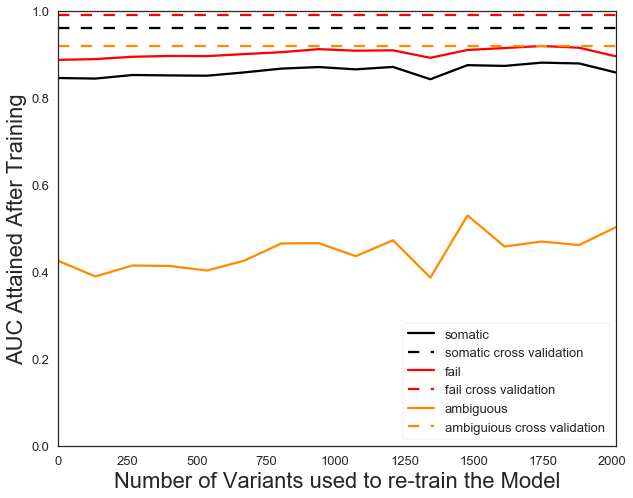

In [49]:
create_batch_effect_retraining_figure(sclc_auc, '/Users/ebarnell/Desktop/Illustrator/figures/Classifier/')

# Breast Test Set

s    284
a    92 
f    67 
Name: call, dtype: int64
confidence intervals +-:  [ 0.01099383  0.06419417  0.10029718  0.0911839   0.08720665  0.10030738
  0.14129092  0.09014795  0.06277861  0.02008171]
Kappa:  0.176642740733
Cohen's Kappa:  0.238206457574


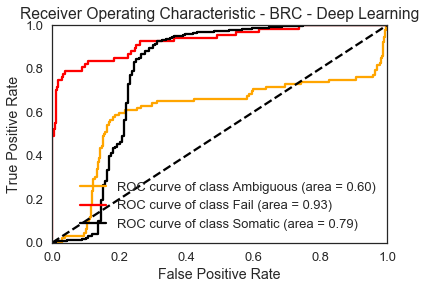

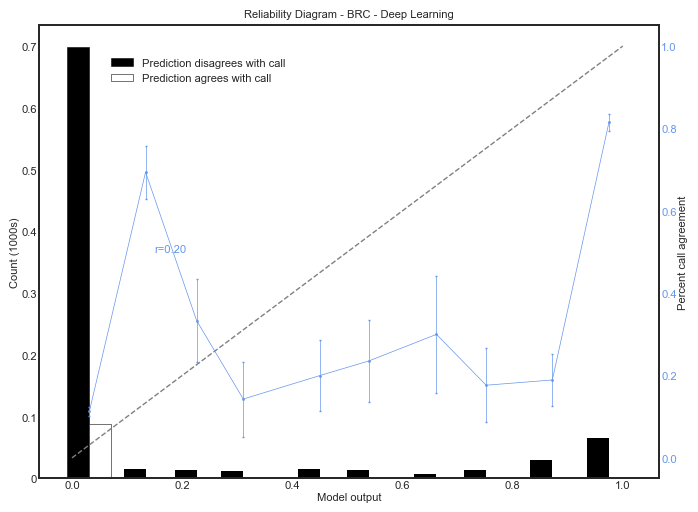

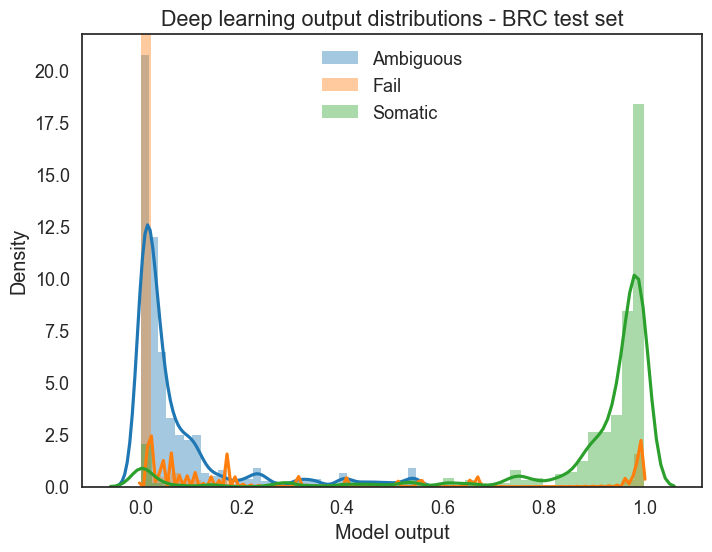

In [62]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
brc_X, brc_Y, brc_probs = determine_independent_test_performance('../data/independent_test/brc_train.pkl',
                                          '../data/independent_test/brc_call.pkl', 1,
                                          ['disease_BRC', 'reviewer_1'], 
                                          estimator,
                                          '../data/independent_test/output_path/',
                                          '../data/independent_test/probability/',
                                          "BRC")

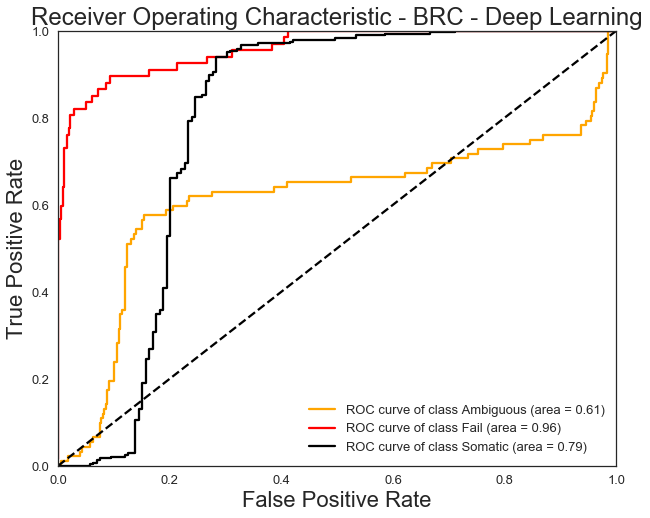

In [60]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(brc_Y, brc_probs, class_lookup, 
                 'ROC - BRC - Deep Learning', ax)
ax.set_ylabel('True Positive Rate', fontsize=22)
ax.set_xlabel('False Positive Rate', fontsize=22)
ax.set_title('Receiver Operating Characteristic - BRC - Deep Learning', fontsize=24)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/BRC_ROC.png', bbox_inches='tight', dpi=1000)

In [55]:
brc_auc = calculate_retraining_improvement(brc_X, brc_Y, X, Y, estimator, 7)

Percentage of test data included in training:  0.0
Training data shape:  (41832, 59)
Test data shape:  (443, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.697516930023

Cross validation classification report

             precision    recall  f1-score   support

          0       0.17      0.03      0.05        92
          1       1.00      0.34      0.51        67
          2       0.70      1.00      0.83       284

avg / total       0.64      0.70      0.62       443

Test AUC:  [0, 0.60182088442958004, 0.92549221975230223, 0.78319603153512274]
---------------------------------------------------------
Percentage of test data included in training:  5.0
Training data shape:  (41854, 59)
Test data shape:  (421, 59)
Number of test samples included in training:  22


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Cross validation accuracy:
	 0.700712589074

Cross validation classification report

             precision    recall  f1-score   support

          0       0.12      0.02      0.04        87
          1       1.00      0.38      0.55        64
          2       0.71      1.00      0.83       270

avg / total       0.63      0.70      0.62       421

Test AUC:  [22, 0.59212609264230143, 0.93220413165266114, 0.77988717194015211]
---------------------------------------------------------
Percentage of test data included in training:  10.0
Training data shape:  (41876, 59)
Test data shape:  (399, 59)
Number of test samples included in training:  44
Cross validation accuracy:
	 0.704260651629

Cross validation classification report

             precision    recall  f1-score   support

          0       0.12      0.02      0.04        83
          1       1.00      0.40      0.57        60
          2       0.71      1.00      0.83       256

avg / total       0.63      0.70      0.63      

Cross validation accuracy:
	 0.684210526316

Cross validation classification report

             precision    recall  f1-score   support

          0       0.11      0.04      0.05        28
          1       1.00      0.25      0.40        20
          2       0.71      1.00      0.83        85

avg / total       0.63      0.68      0.60       133

Test AUC:  [310, 0.59727891156462587, 0.96283185840707952, 0.79705882352941182]
---------------------------------------------------------
Percentage of test data included in training:  75.0
Training data shape:  (42164, 59)
Test data shape:  (111, 59)
Number of test samples included in training:  332
Cross validation accuracy:
	 0.711711711712

Cross validation classification report

             precision    recall  f1-score   support

          0       0.14      0.04      0.07        23
          1       1.00      0.41      0.58        17
          2       0.73      1.00      0.85        71

avg / total       0.65      0.71      0.64    

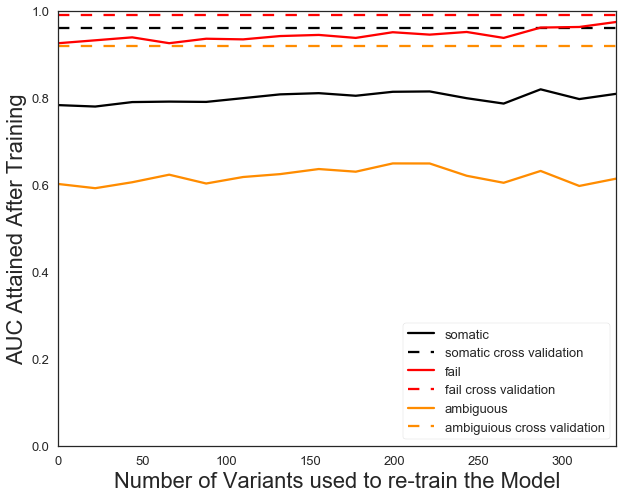

In [68]:
create_batch_effect_retraining_figure(brc_auc, '/Users/ebarnell/Desktop/Illustrator/figures/Classifier/BRC_batch')

# Folicular Lymphoma

In [69]:
fl_data = pd.read_pickle('../data/independent_test/fl_train.pkl')
fl_data = fl_data.drop(['disease_FL'], axis=1)
fl_data = fl_data.drop(['reviewer_NA'], axis=1)
fl_data['solid_tumor'] = 0

In [70]:
fl_call = pd.read_pickle('../data/independent_test/fl_call.pkl')
fl_call = fl_call.map(str.lower).replace('g','f').replace('s\x03', 's').replace('', 'f')
fl_call.value_counts()

s    865
f    858
Name: call, dtype: int64

In [ ]:
fl_Y = pd.get_dummies(fl_call)

In [ ]:
# Get Labels
fl_Y = pd.get_dummies(fl_call)
fl_Y['a'] = 0
fl_Y= fl_Y[['a', 'f', 's']].astype(float).values
# Get training data as numpy array
fl_X = fl_data.sort_index(axis=1).astype(float).values

In [ ]:
fl_probs = estimator.predict_proba(fl_X)

In [ ]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(fl_Y, fl_probs, class_lookup, 
                 'Receiver Operating Characteristic - FL - Deep Learning', ax)
ax.set_ylabel('True Positive Rate', fontsize=22)
ax.set_xlabel('False Positive Rate', fontsize=22)
ax.set_title('Receiver Operating Characteristic - FL - Deep Learning', fontsize=24)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/FL_ROC.png', bbox_inches='tight', dpi=1000)

In [ ]:
seed = 7
auc = []

for i in np.arange(0, 0.8, 0.05):
    if i == 0:
        fl_X_fl = fl_X
        fl_Y_fl = fl_Y
        X_train = X
        Y_train = Y
    else:
        (fl_X_train, fl_X_fl, fl_Y_train, fl_Y_fl) = train_test_split(fl_X, fl_Y, 
                                                       train_size=i,
                                                       random_state=seed, 
                                                       stratify=fl_Y) 
        X_train = np.concatenate((X, fl_X_train))
        Y_train = np.concatenate((Y, fl_Y_train))
    print('Percentage of fl data included in training: ', i*100)
    print('Training data shape: ', X_train.shape)
    print('Fl data shape: ', fl_X_fl.shape)
    print('Number of FL variants included in training: ', X_train.shape[0]-X.shape[0])
    estimator.fit(X_train, Y_train)
    X_fl_probs = estimator.predict_proba(fl_X_fl)
    
    class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
    fig, ax = plt.subplots()
    create_roc_curve(fl_Y_fl, X_fl_probs, class_lookup, 
                     'Receiver Operating Characteristic - FL - Deep Learning', ax)
    ax.set_ylabel('True Positive Rate', fontsize=22)
    ax.set_xlabel('False Positive Rate', fontsize=22)
    ax.set_title('Receiver Operating Characteristic - FL - Deep Learning', fontsize=24)
    fig.set_size_inches(10, 8)
    savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/ROC/FL_ROC' + str(i) + '.png', bbox_inches='tight', dpi=400)
#     print_accuracy_and_classification_report(fl_Y_fl, predict_classes(X_fl_probs))
#     temp_auc = []    
#     for j in range(Y.shape[1]):
#         temp_auc.append([X_train.shape[0]-X.shape[0], 0, 'fail','somatic'])
#     auc.append(temp_auc)
#     print('Test AUC: ', temp_auc)
    print('---------------------------------------------------------')

In [ ]:
fl_auc = [[0, 0, 0.89, 0.891], [86, 0, 0.9, 0.91], [172, 0, 0.84, 0.841], [258, 0, 0.94, 0.914], [344, 0, 0.89, 0.891], 
         [430, 0, 0.92, 0.921], [516, 0, 0.96, 0.961], [603, 0, 0.91, 0.911], [689, 0, 0.91, 0.911], [775, 0, 0.91, 0.911], [861, 0, 0.92, 0.92],
         [861, 0, 0.92, 0.921], [947, 0, 0.92, 0.921], [1033, 0, 0.92, 0.921], [1119, 0, 0.91, 0.911], [1292, 0, 0.94, 0.941]]
fl_auc = pd.DataFrame(fl_auc, columns=['num. FL variants in training','ambiguous', 'fail','somatic'])
fl_auc.to_pickle('../data/deep_learning/fl_batch_effect_correction.pkl')

In [ ]:
# fl_auc = pd.read_pickle('../data/deep_learning/fl_batch_effect_correction.pkl')
fl_auc = pd.DataFrame(fl_auc, columns=['num. FL variants in training','ambiguous', 'fail','somatic'])
# fl_auc.to_pickle('../data/deep_learning/fl_batch_effect_correction.pkl')
fig, ax = plt.subplots(1, 1)
fl_auc.plot(x='num. FL variants in training', y='somatic', ax=ax, color='black')
ax.plot([0, 1292], [.96,.96], linestyle='--', dashes=(5, 5),color='black', label='somatic cross validation')
fl_auc.plot(x='num. FL variants in training', y='fail', ax=ax, color='red')
ax.plot([0, 1292], [.99,.99], linestyle='--', dashes=(5, 5),color='red', label='fail cross validation')
fl_auc.plot(x='num. FL variants in training', y='ambiguous', ax=ax, color='darkorange')
ax.plot([0, 1292], [.92,.92], linestyle='--', dashes=(5, 5),color='darkorange', label='ambiguious cross validation')
ax.set_ylim([0,1.0])
ax.set_ylabel('AUC Attained After Training', fontsize=22)
ax.set_xlabel('Number of Variants used to re-train the Model', fontsize=22)
ax.set_title('', fontsize=24)
ax.legend(loc=4,frameon=True)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/FL_batch.png', bbox_inches='tight', dpi=1000)

# OSCC

f    6891
s    1986
a    293 
Name: call, dtype: int64
confidence intervals +-:  [ 0.00426774  0.00599766  0.0085302   0.01196536  0.01047891  0.01015853
  0.01989744  0.00907782  0.0076563   0.00560054]
Kappa:  -0.0215834695499
Cohen's Kappa:  0.130601188143


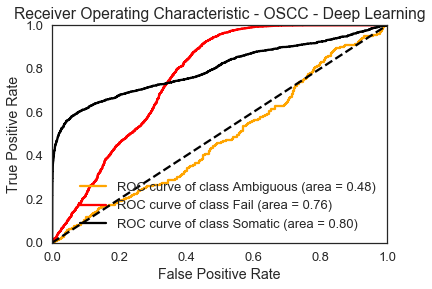

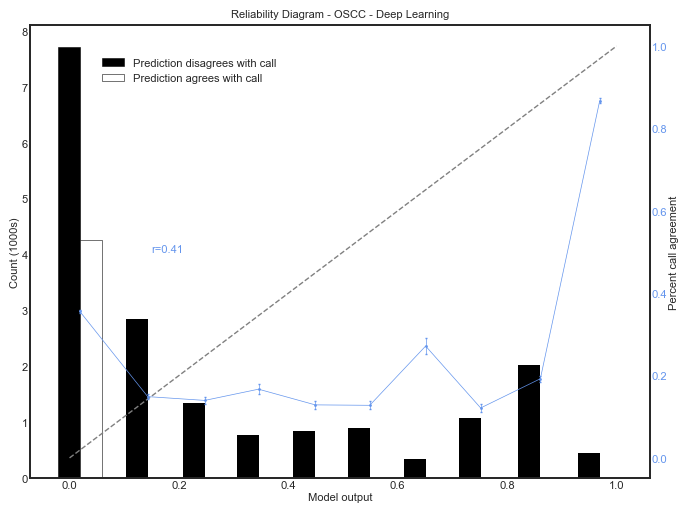

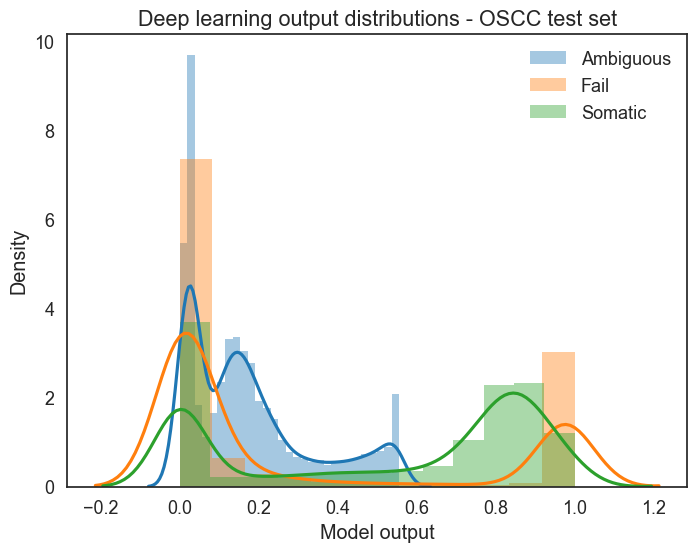

In [63]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
oscc_X, oscc_Y, oscc_probs = determine_independent_test_performance('../data/independent_test/oscc_train.pkl',
                                          '../data/independent_test/oscc_call.pkl', 1,
                                          ['disease_OSCC', 'reviewer_NA'], 
                                          estimator,
                                          '../data/independent_test/output_path/',
                                          '../data/independent_test/probability/',
                                          "OSCC")

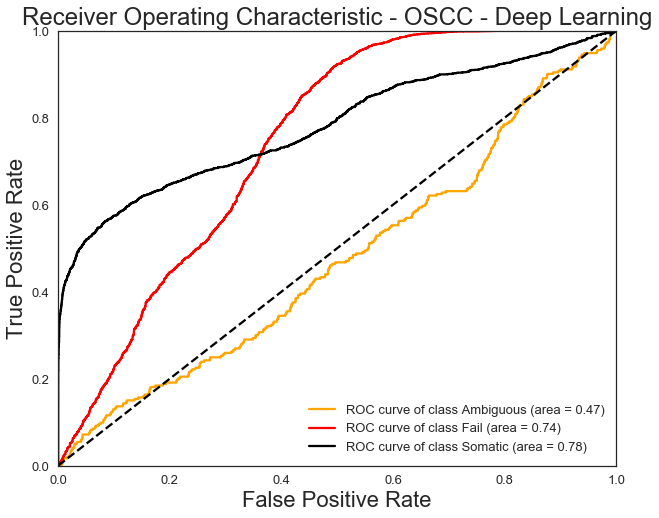

In [61]:
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(oscc_Y, oscc_probs, class_lookup, 
                 'ROC - OSCC - Deep Learning', ax)
ax.set_ylabel('True Positive Rate', fontsize=22)
ax.set_xlabel('False Positive Rate', fontsize=22)
ax.set_title('Receiver Operating Characteristic - OSCC - Deep Learning', fontsize=24)
fig.set_size_inches(10, 8)
savefig('/Users/ebarnell/Desktop/Illustrator/figures/Classifier/OSCC_ROC.png', bbox_inches='tight', dpi=1000)

In [62]:
oscc_auc = calculate_retraining_improvement(oscc_X, oscc_Y, X, Y, estimator, 7)

Percentage of test data included in training:  0.0
Training data shape:  (41832, 59)
Test data shape:  (9170, 59)
Number of test samples included in training:  0
Cross validation accuracy:
	 0.428571428571

Cross validation classification report

             precision    recall  f1-score   support

          0       0.02      0.03      0.03       293
          1       0.87      0.31      0.46      6891
          2       0.28      0.88      0.42      1986

avg / total       0.72      0.43      0.44      9170

Test AUC:  [0, 0.51632761890701162, 0.75447526834353962, 0.79300657217448633]
---------------------------------------------------------


/Users/ebarnell/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Percentage of test data included in training:  5.0
Training data shape:  (42290, 59)
Test data shape:  (8712, 59)
Number of test samples included in training:  458
Cross validation accuracy:
	 0.455578512397

Cross validation classification report

             precision    recall  f1-score   support

          0       0.03      0.17      0.05       278
          1       0.88      0.38      0.53      6547
          2       0.33      0.77      0.46      1887

avg / total       0.73      0.46      0.50      8712

Test AUC:  [458, 0.46908560417494793, 0.75862861928193048, 0.79659626012567186]
---------------------------------------------------------
Percentage of test data included in training:  10.0
Training data shape:  (42749, 59)
Test data shape:  (8253, 59)
Number of test samples included in training:  917
Cross validation accuracy:
	 0.496667878347

Cross validation classification report

             precision    recall  f1-score   support

          0       0.03      0.26      0.0

Percentage of test data included in training:  70.0
Training data shape:  (48251, 59)
Test data shape:  (2751, 59)
Number of test samples included in training:  6419
Cross validation accuracy:
	 0.793529625591

Cross validation classification report

             precision    recall  f1-score   support

          0       0.01      0.05      0.02        88
          1       0.88      0.92      0.90      2067
          2       0.94      0.47      0.63       596

avg / total       0.86      0.79      0.81      2751

Test AUC:  [6419, 0.40461458368893588, 0.80087075655596007, 0.85098646817919932]
---------------------------------------------------------
Percentage of test data included in training:  75.0
Training data shape:  (48709, 59)
Test data shape:  (2293, 59)
Number of test samples included in training:  6877
Cross validation accuracy:
	 0.75752289577

Cross validation classification report

             precision    recall  f1-score   support

          0       0.02      0.11      

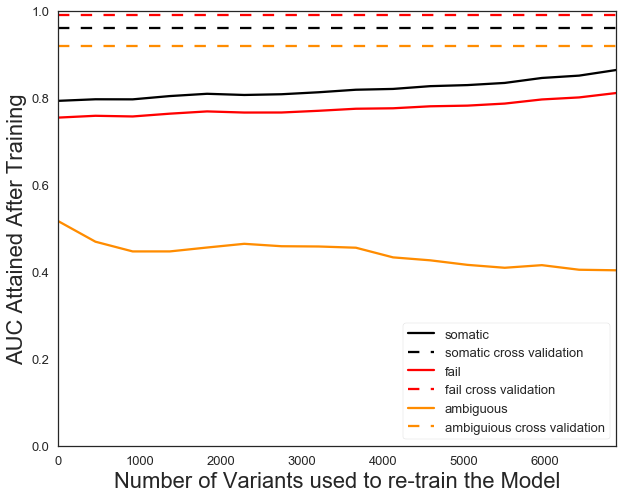

In [64]:
create_batch_effect_retraining_figure(oscc_auc, '/Users/ebarnell/Desktop/Illustrator/figures/Classifier/OSCC_batch')